In [1]:
!source ~/miniconda3/bin/activate sarimax
!pip install matplotlib numpy pmdarima sklearn statsmodels pandas plotly

/bin/bash: /root/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /root/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [10]:
import pickle
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import matplotlib.dates as mdates
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from plotly import graph_objs as go
from pmdarima.arima.utils import ndiffs
import logging
from pmdarima.arima import StepwiseContext
from data_util_common import train_val_test_split, show_box, show_result
import time

In [3]:

def check_stationary(data, lags):
    rolling_mean = data.rolling(window=lags).mean().dropna()
    rolling_std = data.rolling(window=lags).std()
    plt.plot(data, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    dtFmt = mdates.DateFormatter('%Y-%b')  # define the formatting
    plt.gca().xaxis.set_major_formatter(dtFmt)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=0, fontweight='light', fontsize='x-small')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show()


def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(
        'KPSS checks for stochastic trend (e.g., which does not have a constant variance throughout time) stationary.')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    if p_value < 0.05:
        n_kpss = ndiffs(series, test='kpss')
        print(f'N steps required for differencing: {n_kpss}')
    print()


def adf_test(series, **kw):
    result = adfuller(series, **kw)
    print('ADF checks for unit root presence.')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print(f'num lags: {result[2]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""} stationary')
    if result[1] > 0.05:
        n_adf = ndiffs(series, test='adf')
        print(f'N steps required for differencing: {n_adf}')
    print()


def differencing(data, periods):
    data_diff = data.diff(periods)
    data_diff.dropna(inplace=True)
    return data_diff


def remove_seasonality(data, lag):
    seasonal_diff = data - data.shift(lag)
    seasonal_diff = seasonal_diff.dropna(inplace=False)
    return seasonal_diff
    
def canopy_dataset():
    filename = 'data/NIST_Canopy_2015_2018_interpolated.csv'
    label = 'ACP_kW'
    data = pd.read_csv(filename, sep=',')
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S')
    data.set_index(data['TIMESTAMP'], drop=True, inplace=True)
    # data = filter_data(data, "2015-01-01", "2018-01-01")

    data[label] = data[label].astype(float)
    date = [x.strftime('%Y-%m-%d') for x in pd.to_datetime(data.index).date]
    #time = [x.strftime('%H:%M:%S') for x in pd.to_datetime(data.index).time]

    print(data.columns)
    print("Correlation ----------------------------------------------------------------------------------------------")
    corr_data = data.drop(columns=[label, 'season']).corrwith(data[label])
    print(corr_data)

    # pv_per_hour = data[[label]].copy()
    # pv_per_hour['Time'] = time
    # pv_per_hour = pv_per_hour.groupby("Time").agg({label: list}).reset_index()
    # pv_per_hour = pv_per_hour.drop(columns=["Time"])
    # show_box(pv_per_hour, label, "Energy distribution per hour", "Time [h]", "Energy [Wh]")
    # del pv_per_hour
    return data, date, label

Index(['TIMESTAMP', 'ACP_kW', 'Irradiance_1_Wm2', 'Temp_C', 'WindSpeed_ms',
       'season'],
      dtype='object')
Correlation ----------------------------------------------------------------------------------------------
Irradiance_1_Wm2    0.983247
Temp_C              0.346290
WindSpeed_ms        0.348792
dtype: float64
**AUTOCORRELATION ** -------------------------------------------------------------------------------------
The autocorrelation fu nction (ACF) assesses the correlation between observations in a time series for a
set of lags. In an ACF plot, each bar represents the size and direction of the correlation. Bars that
extend across the light blue area are statistically significant. When seasonal patterns are present,
the autocorrelations are larger for lags at multiples of the seasonal frequency than for other lags.


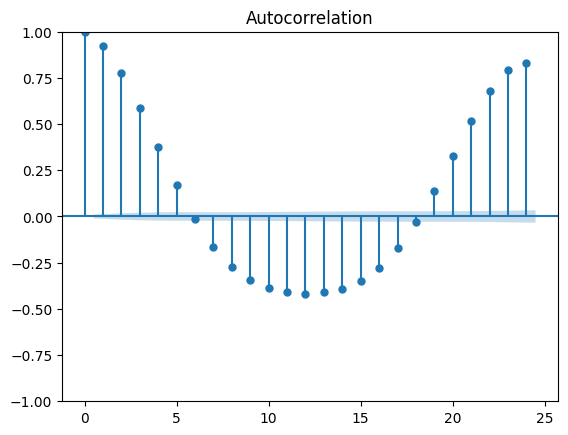

The partial autocorrelation function is similar to the ACF except that it displays only the correlation
between two observations that the shorter lags between those observations do not explain. The most 
statistically significant lags suggests the order of a autoregressive model


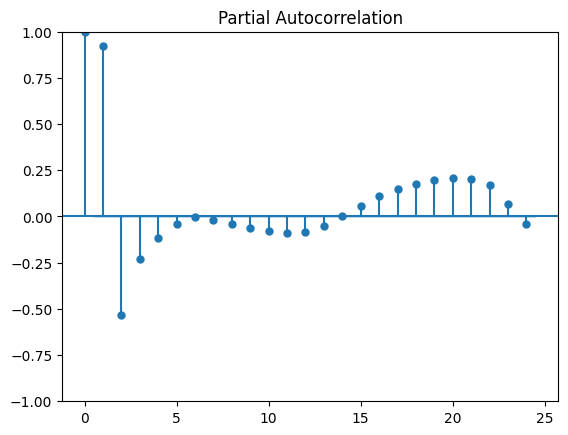

** STATIONARITY ** ---------------------------------------------------------------------------------------
ADF checks for unit root presence.
ADF Statistic: -16.52357884136261
p-value: 0.0
num lags: 24
Critical Values:
	1%: -3.959028395257678
	5%: -3.4106153077405468
	10%: -3.127123795257749
Result: The series is  stationary

KPSS checks for stochastic trend (e.g., which does not have a constant variance throughout time) stationary.
KPSS Statistic: 1.1465991735914305
p-value: 0.01
num lags: 24
Critical Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The series is not stationary
N steps required for differencing: 1

** TRAINING ** -------------------------------------------------------------------------------------------
DATA LEN 35064
****************************************
2018-03-14 19:00:00 - 19
80% - End idx: 28032 - LEN 28032
2018-03-14 00:00:00
****************************************
2018-12-31 05:00:00 - 5
20% - End idx: 35040 - LEN 7008
2018-12-31 0

/tmp/ipykernel_236415/4157623768.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00569D+00    |proj g|=  2.03597D-01


 This problem is unconstrained.



At iterate    5    f=  6.96179D+00    |proj g|=  3.13006D-02

At iterate   10    f=  6.95344D+00    |proj g|=  1.93763D-02

At iterate   15    f=  6.94934D+00    |proj g|=  3.48880D-03

At iterate   20    f=  6.94891D+00    |proj g|=  7.21350D-04

At iterate   25    f=  6.94822D+00    |proj g|=  3.92827D-03

At iterate   30    f=  6.94534D+00    |proj g|=  1.73846D-02

At iterate   35    f=  6.93955D+00    |proj g|=  2.64435D-02

At iterate   40    f=  6.93764D+00    |proj g|=  4.49122D-04

At iterate   45    f=  6.93762D+00    |proj g|=  1.58749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     57   

TypeError: show_result() takes 4 positional arguments but 5 were given

In [4]:

pd.set_option('display.max_columns', None)
format = "%Y-%m-d"
T = 24
data, date, _, label = canopy_dataset()
features = ['Irradiance_1_Wm2']
data = data[[label] + features]

date_time = data.index
data = data.reset_index(drop=True)

# data = differencing(data, 1)
# data = remove_seasonality(data, 24)

print("**AUTOCORRELATION ** -------------------------------------------------------------------------------------")
# px.line(x=data.index, y=data[label], labels={'x': 'Time', 'y': label}).show()
# show_result(data, 'PV plant production', 'Time', label)

print("The autocorrelation fu nction (ACF) assesses the correlation between observations in a time series for a\n"
      "set of lags. In an ACF plot, each bar represents the size and direction of the correlation. Bars that\n"
      "extend across the light blue area are statistically significant. When seasonal patterns are present,\n"
      "the autocorrelations are larger for lags at multiples of the seasonal frequency than for other lags.")
plot_acf(data[label], lags=T)
plt.show()

print("The partial autocorrelation function is similar to the ACF except that it displays only the correlation\n"
      "between two observations that the shorter lags between those observations do not explain. The most \n"
      "statistically significant lags suggests the order of a autoregressive model")

plot_pacf(data[label], lags=T)
plt.show()

print("** STATIONARITY ** ---------------------------------------------------------------------------------------")
# check_stationary(data, lags)
adf_test(data[label], maxlag=T, autolag=None, regression='ct')
kpss_test(data[label], nlags=T, regression='ct')

print("** TRAINING ** -------------------------------------------------------------------------------------------")
# Create the SARIMA model
# p: The number of lag observations included in the model, also called the lag order.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average.

# The (P,D,Q,M) Order refers to the seasonal component of the model for the Auto Regressive parameters,
# differences, Moving Average parameters, and periodicity: D indicates the integration order of the seasonal
# process (the number of transformation needed to make stationary the time series). P indicates the Auto
# Regressive order for the seasonal component. Q indicated the Moving Average order for the seasonal component. M
# indicates the periodicity, i.e. the number of periods in season, such as 12 for monthly data.


split = train_val_test_split(date_time, percentage=[80, 20])
train = data[label][:split[0]]
test = data[label][split[0]:].values
exogenous_train = data[features][:split[0]]
exogenous_test = data[features][split[0]:].values
test_size = len(test)
train_size = len(train)
print(f"TRAIN SIZE {train_size} TEST SIZE {test_size}")

# EXOGENOUS DATA
sarima=None
param_search=False
if param_search:
    with StepwiseContext(max_dur=30):
        sarima = auto_arima(train.values,
                            X=exogenous_train,
                            test='adf',
                            d=None,
                            seasonal=True,
                            D=None,
                            m=T,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            approximation=True,
                            stepwise=True,
                            maxiter=20,
                            method='cg',
                            )
    
    predictions = abs(sarima.predict(n_periods=len(test), X=exogenous_test))
else:
    # MANUAL SARIMA
    order = (2, 0, 2)  # (p, d, q)
    seasonal_order = (1, 0, 1, T)  # (P, D, Q, s)

    print("SARMAX fitting.....")
    start_time = time.time()
    sarima = sm.tsa.SARIMAX(endog=train,
                                exog=exogenous_train,
                                order=order,
                              seasonal_order=seasonal_order
                              ).fit(low_memory=True)
    end_time = time.time()
    print(f"FITTING TIME[s]: {end_time-start_time}")

    print("SARMAX eval.....")
    start_time = time.time()
    predictions = sarima.predict(
            exog=exogenous_test,
            start=train_size, end=train_size+test_size-1)
    end_time = time.time()
    print(f"EVAL TIME[s]: {end_time-start_time}")

print("** TESTING ** --------------------------------------------------------------------------------------------")
print(sarima.summary())

print(f"LOOKBACK\n"
      f"MAE: {mean_absolute_error(test, data[label].values[train_size - T:-T])} ")

print(f"SARIMA\n"
      f"MAE: {mean_absolute_error(test, predictions)} ")

results = pd.DataFrame().from_dict({"Y_True": test, "Y_Pred": predictions})
results.index = date_time[train_size:]
results.to_csv("sarima/results.csv", sep=",")
show_result(results, "SARIMAX forecasting", "Time [h]", "Energy [Wh]", 'sarima/sarima_results.html')

logging.info("SAVING MODEL....")
with open('sarima.pkl', 'wb') as pkl:
    pickle.dump(sarima, pkl)
logging.info("Done.\n")

ONE DAY SARMAX eval.....
EVAL TIME[s]: 0.0041697025299072266
                       Y_True       Y_Pred
TIMESTAMP                                 
2015-01-01 00:00:00     0.000     0.000000
2015-01-01 01:00:00     0.000     0.000000
2015-01-01 02:00:00     0.000     0.000000
2015-01-01 03:00:00     0.000     0.000000
2015-01-01 04:00:00     0.000     0.000000
2015-01-01 05:00:00     0.000     0.000000
2015-01-01 06:00:00    29.953     0.000000
2015-01-01 07:00:00  1478.744    85.968084
2015-01-01 08:00:00  4976.130   687.842323
2015-01-01 09:00:00  7151.130  2753.550190
2015-01-01 10:00:00  5632.780  5152.431362
2015-01-01 11:00:00  6466.900  6459.935005
2015-01-01 12:00:00  6161.190  6603.277909
2015-01-01 13:00:00  6476.270  6128.758944
2015-01-01 14:00:00  6453.720  4350.895621
2015-01-01 15:00:00  4299.940  2160.907841
2015-01-01 16:00:00  2388.050  -475.639847
2015-01-01 17:00:00   322.110  -116.012204
2015-01-01 18:00:00     0.024    42.139754
2015-01-01 19:00:00     0.000    23.

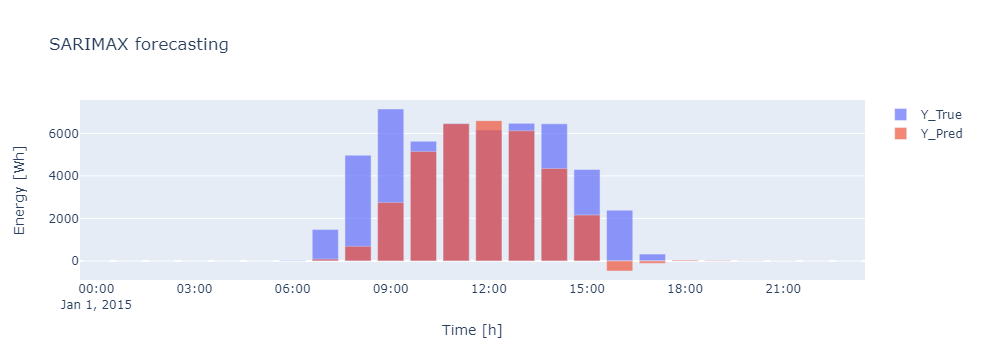

In [13]:
#ONE DAY PRED
print("ONE DAY SARMAX eval.....")
test_size = 24
start_time = time.time()
predictions = sarima.predict(
        exog=exogenous_test[:test_size],
        start=0, end=test_size-1)
end_time = time.time()
print(f"EVAL TIME[s]: {end_time-start_time}")

results = pd.DataFrame().from_dict({"Y_True": test[:test_size], "Y_Pred": predictions})
results.index = date_time[:test_size]
print(results)
show_result(results, "SARIMAX forecasting", "Time [h]", "Energy [Wh]", 'sarima/sarima_results.html')